In [387]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [388]:
import pandas as pd

# Load the salary data
salary = pd.read_csv('data\SalaryData.csv')
salary['PTS_per_GP'] = salary['PTS'] / salary['GP']
salary['AST_TOV_ratio'] = salary['AST'] / salary['TOV']
salary['FG_efficiency'] = salary['FG'] / salary['FGA']


# Drop unnecessary columns
salary2 = salary.drop(['Unnamed: 0', 'Player Name', 'Team'], axis=1)

# Define a mapping for the positions
position_mapping = {
    'PG': 1,
    'SG': 2,
    'SF': 3,
    'PF': 4,
    'C': 5
}

# Apply the position transformation to 'Position' column
salary2['Position'] = salary['Position'].apply(lambda x: x.split('-')[0])
salary2['Position'] = salary2['Position'].replace(position_mapping)

# Remove rows with NaN values
salary2_clean = salary2.dropna()

# Now proceed with feature and target separation after cleaning
features = [col for col in salary2_clean.columns if col != 'Salary']
target = 'Salary'

# Redefine X and y after cleaning
X = salary2_clean[features].values
y = salary2_clean[target].values


C:\Users\conne\AppData\Local\Temp\ipykernel_43188\2723676593.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  salary2['Position'] = salary2['Position'].replace(position_mapping)


In [389]:
salary2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Salary         467 non-null    int64  
 1   Position       467 non-null    int64  
 2   Age            467 non-null    int64  
 3   GP             467 non-null    int64  
 4   GS             467 non-null    int64  
 5   MP             467 non-null    float64
 6   FG             467 non-null    float64
 7   FGA            467 non-null    float64
 8   FG%            466 non-null    float64
 9   3P             467 non-null    float64
 10  3PA            467 non-null    float64
 11  3P%            454 non-null    float64
 12  2P             467 non-null    float64
 13  2PA            467 non-null    float64
 14  2P%            463 non-null    float64
 15  eFG%           466 non-null    float64
 16  FT             467 non-null    float64
 17  FTA            467 non-null    float64
 18  FT%       

In [390]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for rows with Inf in X_train and remove them from both X_train and y_train
inf_mask_train = np.isinf(X_train).any(axis=1)
X_train = X_train[~inf_mask_train]
y_train = y_train[~inf_mask_train]

# Check for rows with Inf in X_test and remove them from both X_test and y_test
inf_mask_test = np.isinf(X_test).any(axis=1)
X_test = X_test[~inf_mask_test]
y_test = y_test[~inf_mask_test]


# Standardize the features (important for neural networks)
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Standardize the target (salary) values
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))  # Reshape to 2D
y_test = scaler_y.transform(y_test.reshape(-1, 1))

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Already 2D
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [391]:
import numpy as np

# Check for NaN values
print(f"Any NaN in X_train: {np.isnan(X_train).any()}")
print(f"Any NaN in X_test: {np.isnan(X_test).any()}")

# Check for Inf values
print(f"Any Inf in X_train: {np.isinf(X_train).any()}")
print(f"Any Inf in X_test: {np.isinf(X_test).any()}")


Any NaN in X_train: False
Any NaN in X_test: False
Any Inf in X_train: False
Any Inf in X_test: False


In [392]:
class SalaryPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,dropout_prob = 0.5):
        super(SalaryPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [393]:
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # Hidden layer size (can be adjusted)
output_size = 1   # Single output (salary)

model = SalaryPredictor(input_size, hidden_size, output_size)

In [394]:
criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [395]:
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass: Compute predicted y by passing X to the model
    predictions = model(X_train_tensor)

    # Compute the loss
    loss = criterion(predictions, y_train_tensor)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.5172
Epoch [200/1000], Loss: 0.3673
Epoch [300/1000], Loss: 0.2859
Epoch [400/1000], Loss: 0.2163
Epoch [500/1000], Loss: 0.1653
Epoch [600/1000], Loss: 0.1315
Epoch [700/1000], Loss: 0.1070
Epoch [800/1000], Loss: 0.0891
Epoch [900/1000], Loss: 0.0737
Epoch [1000/1000], Loss: 0.0607


In [396]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")


Shape of X_train: (342, 51)
Shape of y_train: (342, 1)


In [397]:
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.4781


In [398]:
# Inverse transform the predictions to get the actual salary values
test_predictions_scaled = model(X_test_tensor)
test_predictions = scaler_y.inverse_transform(test_predictions_scaled.detach().numpy())

# Also, inverse transform the y_test_scaled to compare the true salary values
y_test_original = scaler_y.inverse_transform(y_test_tensor.detach().numpy())

# Compare predictions and actual salaries
print(test_predictions[:5])  # First 5 predicted salaries
print(y_test_original[:5])   # First 5 actual salaries


[[  579986.06]
 [ 3721718.5 ]
 [ 2090601.  ]
 [18237008.  ]
 [ 2937529.  ]]
[[  102910.055]
 [16902000.   ]
 [ 5739840.   ]
 [31650600.   ]
 [  508891.06 ]]


In [399]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE on the original scale
mae = mean_absolute_error(y_test_original, test_predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate R² score on the original scale
r2 = r2_score(y_test_original, test_predictions)
print(f'R² Score: {r2:.2f}')


Mean Absolute Error (MAE): 4788815.50
R² Score: 0.62


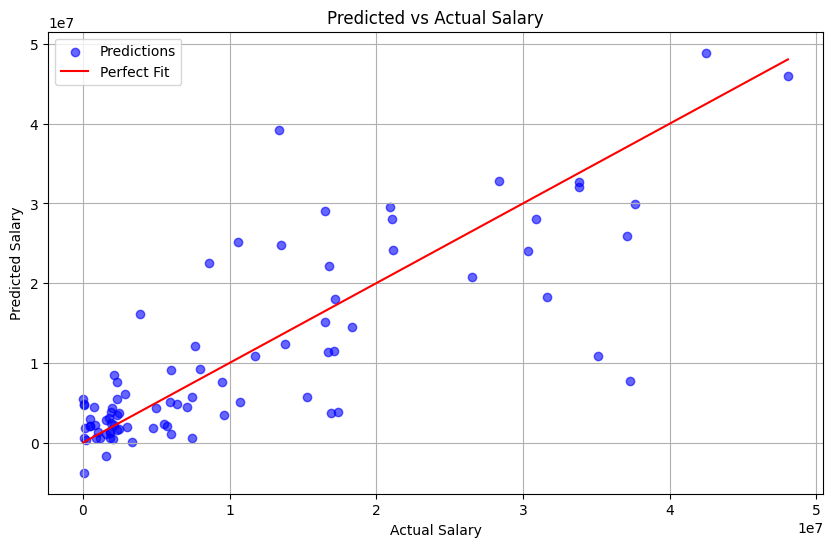

In [400]:
import matplotlib.pyplot as plt

# Assuming `test_predictions` and `y_test_original` are already defined from the previous step.
# Create the predicted vs actual salary graph

# Plot predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, test_predictions, color='blue', label='Predictions', alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', label='Perfect Fit')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Predicted vs Actual Salary')
plt.legend()
plt.grid(True)
plt.show()


In [401]:
import numpy as np

# Calculate z-scores for each feature in X_train
from scipy import stats
z_scores = np.abs(stats.zscore(X_train))

# Define a threshold for the z-score
threshold = 3  # Points with a z-score above 3 are considered outliers

# Identify outliers in X_train
outliers = np.where(z_scores > threshold)

# Remove the outliers
X_train = X_train[(z_scores < threshold).all(axis=1)]
y_train = y_train[(z_scores < threshold).all(axis=1)]


In [403]:
# Save the model weights after training
torch.save(model.state_dict(), 'model_weights.pth')
